In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 5)
import torch
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer

import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/punkboy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def tokenize_text(texts):
    stop_words = set(stopwords.words('english'))
    tokenized_texts = [text.split() for text in texts]
    tokenized_texts = [[word for word in text if word.lower() not in stop_words] for text in tokenized_texts]
    phrases = Phrases(tokenized_texts, min_count=1, threshold=1)
    bigram = Phraser(phrases)
    collocation_texts = [bigram[text] for text in tokenized_texts]
    return tokenized_texts

In [3]:
# Importing the S&P 500 File

sp = pd.read_csv("SP500_data.csv")

sp['Return'] = sp['Adj Close'].pct_change() * 100

sp.rename(columns = {"Date" : "date"},inplace = True)

sp_new = sp[["date","Return"]]
sp_new.head()

sp_new["date"] = pd.to_datetime(sp_new["date"])

# Looking 1 day ahead
sp_new['Day_Avg_Return'] = sp_new['Return'].rolling(window=1, min_periods=1).mean().shift(-1)
sp_new['Day_Later'] = sp_new['date'] + pd.Timedelta(days=1)

# Looking 7 days ahead (1 week)
sp_new['7_Day_Avg_Return'] = sp_new['Return'].rolling(window=7, min_periods=1).mean().shift(-7)
sp_new['Date_7_Days_Later'] = sp_new['date'] + pd.Timedelta(days=7)

# Looking 14 days ahead (2 weeks)
sp_new['14_Day_Avg_Return'] = sp_new['Return'].rolling(window=14, min_periods=1).mean().shift(-14)
sp_new['Date_14_Days_Later'] = sp_new['date'] + pd.Timedelta(days=14)

sp_new = sp_new.round(2)
sp_new.head(10)

/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3186153453.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_new["date"] = pd.to_datetime(sp_new["date"])
/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3186153453.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_new['Day_Avg_Return'] = sp_new['Return'].rolling(window=1, min_periods=1).mean().shift(-1)
/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3186153453.py:16: SettingWithCopyWarning: 
A va

,date,Return,...,14_Day_Avg_Return,Date_14_Days_Later
0,2018-02-05,NaN,...,0.35,2018-02-19
1,2018-02-06,1.74,...,0.14,2018-02-20
2,2018-02-07,-0.50,...,0.10,2018-02-21
3,2018-02-08,-3.75,...,0.27,2018-02-22
4,2018-02-09,1.49,...,0.20,2018-02-23
5,2018-02-12,1.39,...,0.18,2018-02-26
6,2018-02-13,0.26,...,0.18,2018-02-27
7,2018-02-14,1.34,...,0.08,2018-02-28
8,2018-02-15,1.21,...,0.02,2018-03-01
9,2018-02-16,0.04,...,0.15,2018-03-02


In [4]:
# Importing the VIX File

vix = pd.read_csv("VIX_data.csv")

vix['Return'] = vix['Adj Close'].pct_change() * 100

vix.rename(columns = {"Date" : "date"},inplace = True)

vix_new = vix[["date","Return"]]

vix_new["date"] = pd.to_datetime(vix_new["date"])

# Looking 1 day ahead
vix_new['Day_Avg_Return'] = vix_new['Return'].rolling(window=1, min_periods=1).mean().shift(-1)
vix_new['Day_Later'] = vix_new['date'] + pd.Timedelta(days=1)

# Looking 7 days ahead (1 week)
vix_new['7_Day_Avg_Return'] = vix_new['Return'].rolling(window=7, min_periods=1).mean().shift(-7)
vix_new['Date_7_Days_Later'] = vix_new['date'] + pd.Timedelta(days=7)

# Looking 14 days ahead (2 weeks)
vix_new['14_Day_Avg_Return'] = vix_new['Return'].rolling(window=14, min_periods=1).mean().shift(-14)
vix_new['Date_14_Days_Later'] = vix_new['date'] + pd.Timedelta(days=14)

vix_new = vix_new.round(2)
vix_new.head(10)

/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3303544661.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_new["date"] = pd.to_datetime(vix_new["date"])
/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3303544661.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_new['Day_Avg_Return'] = vix_new['Return'].rolling(window=1, min_periods=1).mean().shift(-1)
/var/folders/y_/_grw67fs17q7m8576cdd6gb00000gn/T/ipykernel_12139/3303544661.py:15: SettingWithCopyWarning: 


,date,Return,...,14_Day_Avg_Return,Date_14_Days_Later
0,2018-02-05,NaN,...,-5.39,2018-02-19
1,2018-02-06,-19.67,...,-2.72,2018-02-20
2,2018-02-07,-7.51,...,-1.70,2018-02-21
3,2018-02-08,20.66,...,-2.23,2018-02-22
4,2018-02-09,-13.15,...,-2.21,2018-02-23
5,2018-02-12,-11.87,...,-1.67,2018-02-26
6,2018-02-13,-2.50,...,-1.64,2018-02-27
7,2018-02-14,-22.87,...,-0.24,2018-02-28
8,2018-02-15,-0.67,...,-0.68,2018-03-01
9,2018-02-16,1.73,...,-1.62,2018-03-02


In [5]:
df = pd.read_csv('482 Cleaned Data 2.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
tokenized_articles = tokenize_text(df['text'])
df.head()

date  \
0 2018-02-13   
1 2018-02-27   
2 2018-04-06   
3 2018-05-08   
4 2018-05-25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [6]:
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [7]:
def encode(data):
    tokens = tokenizer.encode_plus(data, add_special_tokens = False, return_tensors = 'pt')
    """
    This function splits the input_ids and attention_mask into chunks of size 'chunksize'. 
    It also adds special tokens (101 for [CLS] and 102 for [SEP]) at the start and end of each chunk.
    If the length of a chunk is less than 'chunksize', it pads the chunk with zeros at the end.
    
    Returns:
        input_id_chunks (List[torch.Tensor]): List of chunked input_ids.
        attention_mask_chunks (List[torch.Tensor]): List of chunked attention_masks.
    """
    chunksize = 512
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    attention_mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))
    
    for i in range(len(input_id_chunks)):
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        
        attention_mask_chunks[i] = torch.cat([
            torch.tensor([1]), attention_mask_chunks[i], torch.tensor([1])
        ])
        
        pad_length = chunksize - input_id_chunks[i].shape[0]
        
        if pad_length > 0:
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_length)
            ])
            attention_mask_chunks[i] = torch.cat([
                attention_mask_chunks[i], torch.Tensor([0] * pad_length)
            ])
            
    return input_id_chunks, attention_mask_chunks

In [8]:
negative_scores = []
positive_scores = []
neutral_scores = []

for text in tokenized_articles:
    input_id_chunks, attention_mask_chunks = encode(text)

    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(attention_mask_chunks)

    input_dict = {
        'input_ids' : input_ids.long(),
        'attention_mask' : attention_mask.int()
    }

    outputs = model(**input_dict)
    probabilities = torch.nn.functional.softmax(outputs[0], dim =- 1)
    mean_probabilities = probabilities.mean(dim = 0)

    # Storing the scores together
    negative_scores.append(mean_probabilities[0].item())
    positive_scores.append(mean_probabilities[1].item())
    neutral_scores.append(mean_probabilities[2].item())

Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors


In [9]:
sentiment_analyzer = SentimentIntensityAnalyzer()

dates = []
negative_scores2 = []
neutral_scores2 = []
positive_scores2 = []

for date, headline in zip(df['date'], df['text']):
    sentiment_scores = sentiment_analyzer.polarity_scores(headline)
    
    dates.append(date)
    negative_scores2.append(sentiment_scores['neg'])
    neutral_scores2.append(sentiment_scores['neu'])
    positive_scores2.append(sentiment_scores['pos'])

daily_sentiments_df = pd.DataFrame({
    'date': dates,
    'Vader_Negative': negative_scores2,
    'Vader_Neutral': neutral_scores2,
    'Vader_Positive': positive_scores2,
    'FinBert_Negative': negative_scores,
    'FinBert_Neutral': neutral_scores,
    'FinBert_Positive': positive_scores
})


In [10]:
merged_sp = pd.merge(daily_sentiments_df, sp_new, left_on='date', right_on='date')
#merged_sp.drop(columns=['text'], inplace=True)

In [11]:
merged_vix = pd.merge(daily_sentiments_df, vix_new, left_on='date', right_on='date')
#merged_vix.drop(columns=['text'], inplace=True)
merged_vix

,date,Vader_Negative,...,14_Day_Avg_Return,Date_14_Days_Later
0,2018-02-13,0.051,...,-1.64,2018-02-27
1,2018-02-27,0.058,...,0.56,2018-03-13
2,2018-04-06,0.086,...,-1.83,2018-04-20
3,2018-05-08,0.065,...,1.43,2018-05-22
4,2018-05-25,0.087,...,-0.27,2018-06-08
5,2018-06-20,0.126,...,0.94,2018-07-04
6,2018-07-17,0.062,...,-0.35,2018-07-31
7,2018-08-24,0.090,...,0.16,2018-09-07
8,2018-09-27,0.091,...,3.37,2018-10-11
9,2018-10-02,0.116,...,4.52,2018-10-16


In [12]:
merged_sp

,date,Vader_Negative,...,14_Day_Avg_Return,Date_14_Days_Later
0,2018-02-13,0.051,...,0.18,2018-02-27
1,2018-02-27,0.058,...,-0.08,2018-03-13
2,2018-04-06,0.086,...,0.17,2018-04-20
3,2018-05-08,0.065,...,0.05,2018-05-22
4,2018-05-25,0.087,...,0.15,2018-06-08
5,2018-06-20,0.126,...,0.02,2018-07-04
6,2018-07-17,0.062,...,0.10,2018-07-31
7,2018-08-24,0.090,...,0.08,2018-09-07
8,2018-09-27,0.091,...,-0.25,2018-10-11
9,2018-10-02,0.116,...,-0.41,2018-10-16


In [13]:
#Random Forest SP Day Avg 
target = 'Avg Day Return'
temp = pd.DataFrame()
#temp['date'] = merged_sp['date']
temp['Finbert Negative'] = merged_sp['FinBert_Negative']
temp['Finbert Neutral'] = merged_sp['FinBert_Neutral']
temp['Finbert Postitive'] = merged_sp['FinBert_Positive']
temp['Avg Day Return'] = merged_sp['Day_Avg_Return']
#temp['7 Day Avg Return'] =  merged_sp['7_Day_Avg_Return']
#temp['14 Day Avg Return'] = merged_sp['14_Day_Avg_Return']


,max_depth,score
0,1,-1.191056
1,2,-1.258374
2,3,-1.580721
3,4,-1.918566
4,5,-1.955451
5,6,-1.925898
6,7,-2.343526
7,8,-1.875174
8,9,-1.938515
9,10,-2.466807


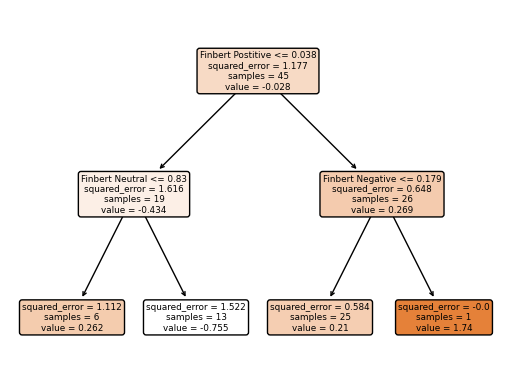

In [14]:
pd.set_option('display.max_columns', None)
X = temp.drop(target, axis=1)
y = temp[target].astype(float).values
feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(X_train, y_train)
_ = plot_tree(dtree, 
              feature_names=feature_names,
              class_names=temp[target].unique(),
              filled=True, rounded=True)
def mse_gs_cv(model, params, X, y):
    grid_search = GridSearchCV(model, params, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)
    res = grid_search.cv_results_
    return pd.DataFrame(
        {p_name: res[f"param_{p_name}"].data for p_name in params.keys()}
        | {"score": res["mean_test_score"]}
    )

mse_gs_cv(dtree, {"max_depth": range(1, 14, 1)}, X, y)

1.0222894101576692


<BarContainer object of 3 artists>

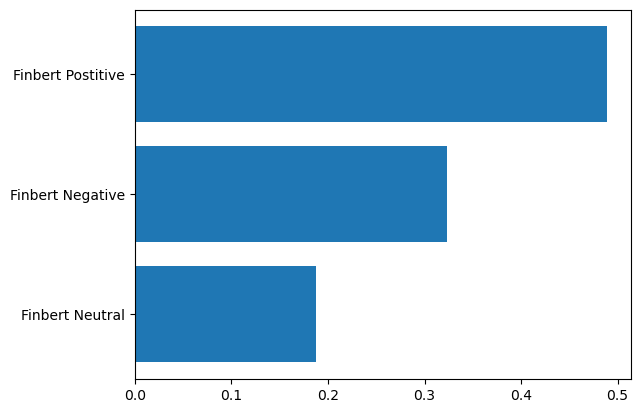

In [15]:
rforest = RandomForestRegressor(max_depth=2)
rforest.fit(X_train, y_train)
print(mean_squared_error(y_test, rforest.predict(X_test)))
snames, simportances = zip(*sorted(zip(feature_names, rforest.feature_importances_), 
                                   key=lambda pair: pair[1]))
plt.barh(snames, simportances)

Gradient Boosted R-Squared:  -0.1568571360767539
Random Forest R-Squared:  0.03374886142989231


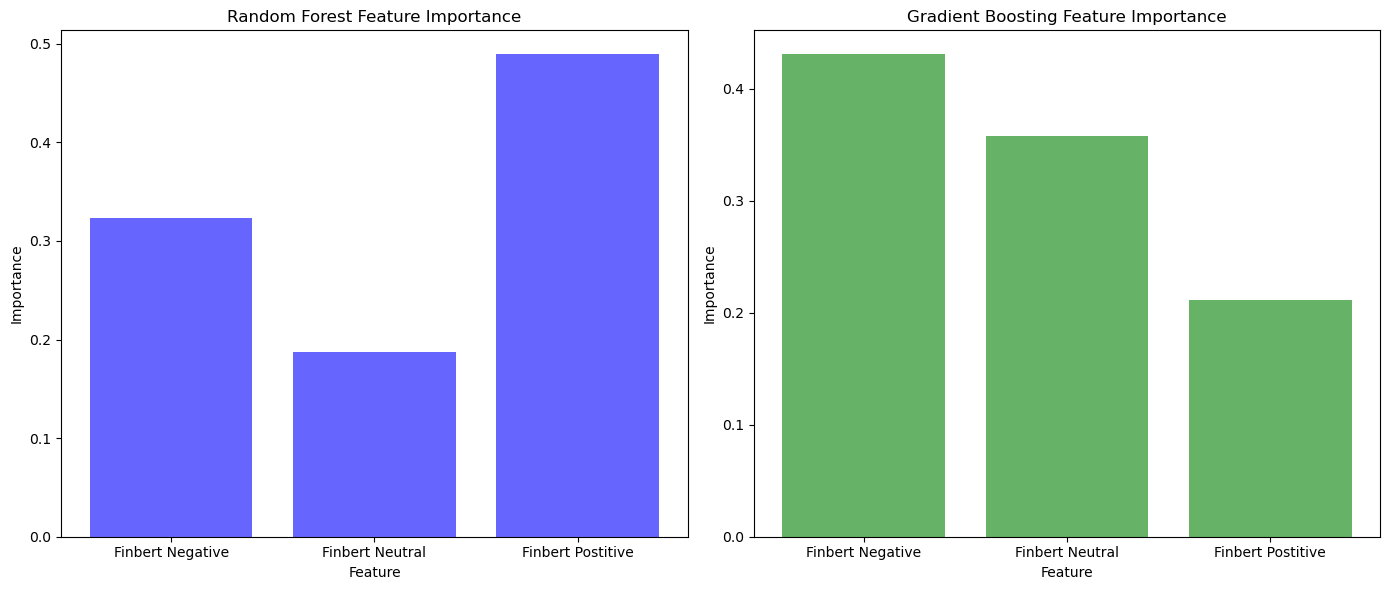

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=2, random_state=42)
gb_reg.fit(X_train, y_train)
score = gb_reg.score(X_test, y_test)
scorerf = rforest.score(X_test,y_test)
print('Gradient Boosted R-Squared: ',score)
print('Random Forest R-Squared: ',scorerf)
# Get feature importances
rf_importance = rforest.feature_importances_
gb_importance = gb_reg.feature_importances_

# Plot the feature importances
feature_labels = X_train.columns.tolist()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(feature_labels, rf_importance, color='blue', alpha=0.6, label='Random Forest')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.subplot(1, 2, 2)
plt.bar(feature_labels, gb_importance, color='green', alpha=0.6, label='Gradient Boosting')
plt.title('Gradient Boosting Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.tight_layout()
plt.show()

In [17]:
#Random Forest SP 7 Day Avg 
target = '7 Day Avg Return'
temp = pd.DataFrame()
temp['Finbert Negative'] = merged_sp['FinBert_Negative']
temp['Finbert Neutral'] = merged_sp['FinBert_Neutral']
temp['Finbert Postitive'] = merged_sp['FinBert_Positive']
#temp['Avg Day Return'] = merged_sp['Day_Avg_Return']
temp['7 Day Avg Return'] =  merged_sp['7_Day_Avg_Return']
#temp['14 Day Avg Return'] = merged_sp['14_Day_Avg_Return']

,max_depth,score
0,1,-0.142385
1,2,-0.255831
2,3,-0.284666
3,4,-0.304310
4,5,-0.249997
5,6,-0.256681
6,7,-0.290805
7,8,-0.333250
8,9,-0.263371
9,10,-0.296592


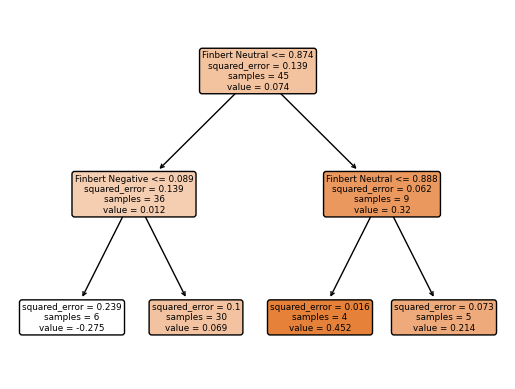

In [18]:
X = temp.drop(target, axis=1)
y = temp[target].astype(float).values
feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(X_train, y_train)
_ = plot_tree(dtree, 
              feature_names=feature_names,
              class_names=temp[target].unique(),
              filled=True, rounded=True)
mse_gs_cv(dtree, {"max_depth": range(1, 14, 1)}, X, y)

0.16418250684550478


<BarContainer object of 3 artists>

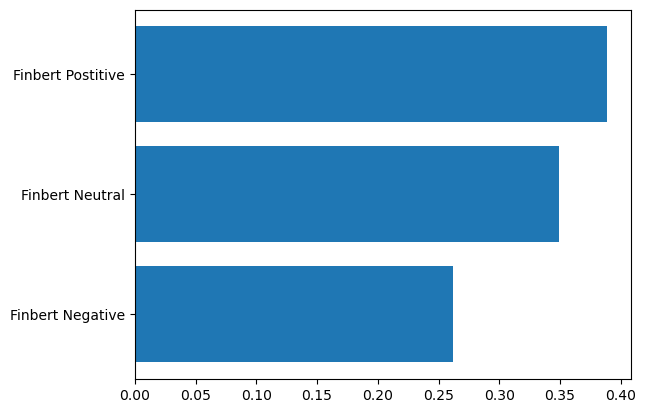

In [19]:
rforest = RandomForestRegressor(max_depth=2)
rforest.fit(X_train, y_train)
print(mean_squared_error(y_test, rforest.predict(X_test)))
snames, simportances = zip(*sorted(zip(feature_names, rforest.feature_importances_), 
                                   key=lambda pair: pair[1]))
plt.barh(snames, simportances)

Gradient Boosted R-Squared:  -0.006983258771624312
Random Forest R-Squared:  0.017874905213605352


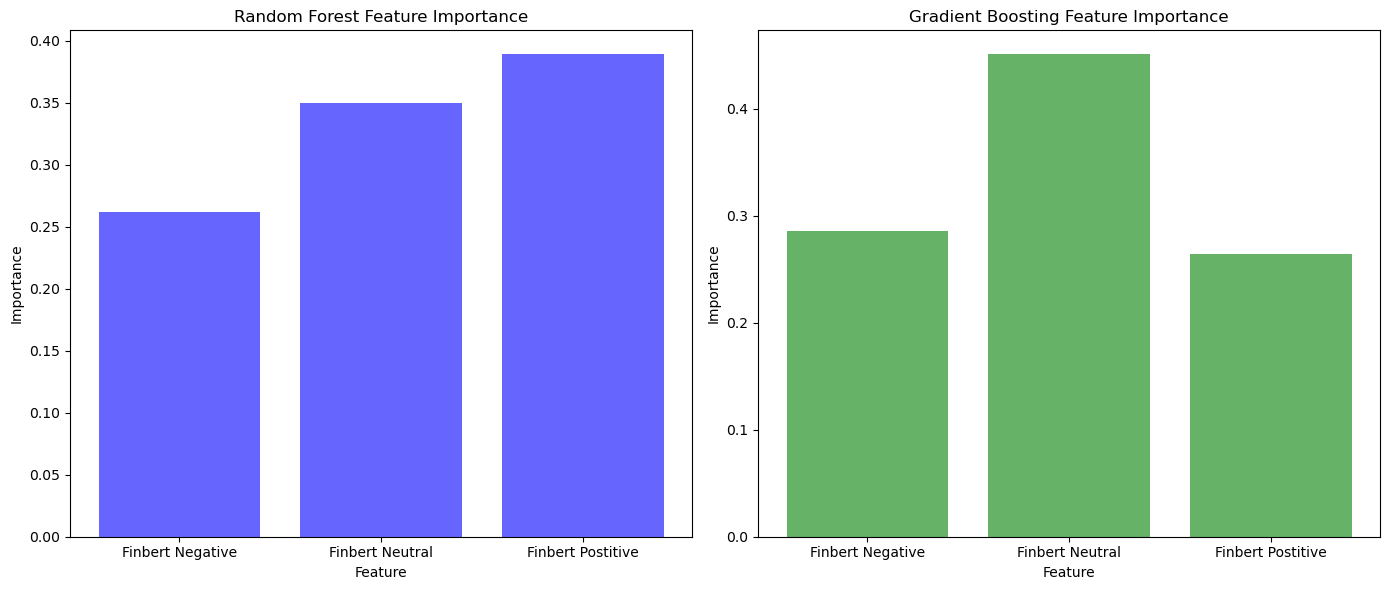

In [20]:
gb_reg = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=2, random_state=42)
gb_reg.fit(X_train, y_train)
score = gb_reg.score(X_test, y_test)
scorerf = rforest.score(X_test,y_test)
print('Gradient Boosted R-Squared: ',score)
print('Random Forest R-Squared: ',scorerf)
# Get feature importances
rf_importance = rforest.feature_importances_
gb_importance = gb_reg.feature_importances_

# Plot the feature importances
feature_labels = X_train.columns.tolist()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(feature_labels, rf_importance, color='blue', alpha=0.6, label='Random Forest')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.subplot(1, 2, 2)
plt.bar(feature_labels, gb_importance, color='green', alpha=0.6, label='Gradient Boosting')
plt.title('Gradient Boosting Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.tight_layout()
plt.show()

In [21]:
merged_vix

,date,Vader_Negative,Vader_Neutral,Vader_Positive,FinBert_Negative,FinBert_Neutral,FinBert_Positive,Return,Day_Avg_Return,Day_Later,7_Day_Avg_Return,Date_7_Days_Later,14_Day_Avg_Return,Date_14_Days_Later
0,2018-02-13,0.051,0.648,0.301,0.088871,0.889390,0.021739,-2.50,-22.87,2018-02-14,-5.31,2018-02-20,-1.64,2018-02-27
1,2018-02-27,0.058,0.750,0.193,0.138663,0.794597,0.066741,17.66,6.78,2018-02-28,-1.33,2018-03-06,0.56,2018-03-13
2,2018-04-06,0.086,0.751,0.163,0.099566,0.634507,0.265928,13.46,1.30,2018-04-07,-4.72,2018-04-13,-1.83,2018-04-20
3,2018-05-08,0.065,0.834,0.101,0.110437,0.825143,0.064419,-0.27,-8.77,2018-05-09,-1.06,2018-05-15,1.43,2018-05-22
4,2018-05-25,0.087,0.740,0.173,0.094852,0.874447,0.030701,5.51,28.74,2018-05-26,-1.02,2018-06-01,-0.27,2018-06-08
5,2018-06-20,0.126,0.698,0.176,0.217136,0.657611,0.125252,-4.19,14.46,2018-06-21,4.04,2018-06-27,0.94,2018-07-04
6,2018-07-17,0.062,0.705,0.234,0.128838,0.839032,0.032129,-6.00,0.33,2018-07-18,0.13,2018-07-24,-0.35,2018-07-31
7,2018-08-24,0.090,0.766,0.143,0.092206,0.816613,0.091181,-3.38,1.42,2018-08-25,2.25,2018-08-31,0.16,2018-09-07
8,2018-09-27,0.091,0.508,0.401,0.201630,0.779253,0.019118,-3.72,-2.34,2018-09-28,3.72,2018-10-04,3.37,2018-10-11
9,2018-10-02,0.116,0.780,0.104,0.071435,0.846384,0.082181,0.42,-3.65,2018-10-03,11.90,2018-10-09,4.52,2018-10-16


In [22]:
#Random Forest VIX Avg Day Return
target = 'Avg Day Return'
temp = pd.DataFrame()
#temp['date'] = merged_sp['date']
temp['Finbert Negative'] = merged_vix['FinBert_Negative']
temp['Finbert Neutral'] = merged_vix['FinBert_Neutral']
temp['Finbert Postitive'] = merged_vix['FinBert_Positive']
temp['Avg Day Return'] = merged_vix['Day_Avg_Return']
#temp['7 Day Avg Return'] =  merged_sp['7_Day_Avg_Return']
#temp['14 Day Avg Return'] = merged_sp['14_Day_Avg_Return']

,max_depth,score
0,1,-93.300448
1,2,-104.113762
2,3,-130.303297
3,4,-123.468912
4,5,-135.566053
5,6,-139.116250
6,7,-154.064586
7,8,-162.706214
8,9,-155.039955
9,10,-154.826719


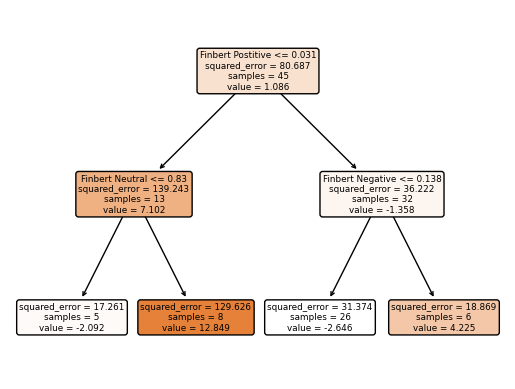

In [23]:
X = temp.drop(target, axis=1)
y = temp[target].astype(float).values
feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(X_train, y_train)
_ = plot_tree(dtree, 
              feature_names=feature_names,
              class_names=temp[target].unique(),
              filled=True, rounded=True)
mse_gs_cv(dtree, {"max_depth": range(1, 14, 1)}, X, y)

103.46163396254627


<BarContainer object of 3 artists>

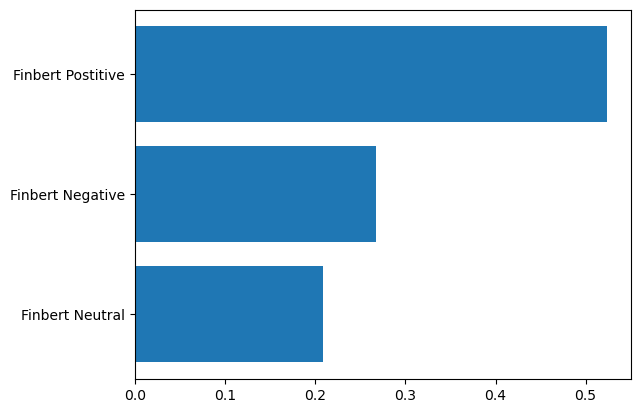

In [24]:
rforest = RandomForestRegressor(max_depth=2)
rforest.fit(X_train, y_train)
print(mean_squared_error(y_test, rforest.predict(X_test)))
snames, simportances = zip(*sorted(zip(feature_names, rforest.feature_importances_), 
                                   key=lambda pair: pair[1]))
plt.barh(snames, simportances)

Gradient Boosted R-Squared:  -0.0989330246020137
Random Forest R-Squared:  -0.35427168139232856


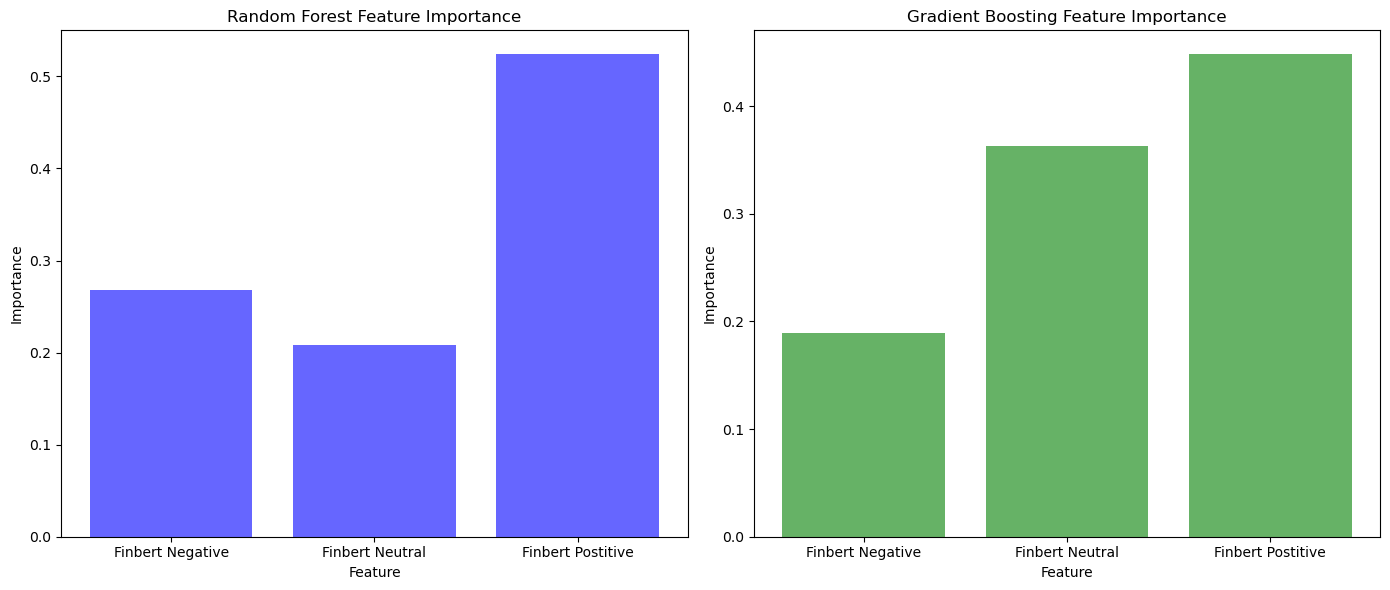

In [25]:
gb_reg = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=2, random_state=42)
gb_reg.fit(X_train, y_train)
score = gb_reg.score(X_test, y_test)
scorerf = rforest.score(X_test,y_test)
print('Gradient Boosted R-Squared: ',score)
print('Random Forest R-Squared: ',scorerf)
# Get feature importances
rf_importance = rforest.feature_importances_
gb_importance = gb_reg.feature_importances_

# Plot the feature importances
feature_labels = X_train.columns.tolist()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(feature_labels, rf_importance, color='blue', alpha=0.6, label='Random Forest')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.subplot(1, 2, 2)
plt.bar(feature_labels, gb_importance, color='green', alpha=0.6, label='Gradient Boosting')
plt.title('Gradient Boosting Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.tight_layout()
plt.show()

In [26]:
target = '7 Day Avg Return'
temp = pd.DataFrame()
#temp['date'] = merged_sp['date']
temp['Finbert Negative'] = merged_vix['FinBert_Negative']
temp['Finbert Neutral'] = merged_vix['FinBert_Neutral']
temp['Finbert Postitive'] = merged_vix['FinBert_Positive']
#temp['Avg Day Return'] = merged_vix['Day_Avg_Return']
temp['7 Day Avg Return'] =  merged_vix['7_Day_Avg_Return']
#temp['14 Day Avg Return'] = merged_sp['14_Day_Avg_Return']

,max_depth,score
0,1,-10.455065
1,2,-11.999065
2,3,-16.233548
3,4,-20.590309
4,5,-17.488094
5,6,-21.275977
6,7,-19.162245
7,8,-18.996450
8,9,-19.638657
9,10,-18.733172


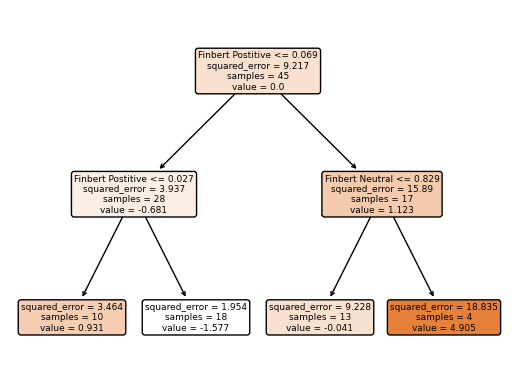

In [27]:
X = temp.drop(target, axis=1)
y = temp[target].astype(float).values
feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(X_train, y_train)
_ = plot_tree(dtree, 
              feature_names=feature_names,
              class_names=temp[target].unique(),
              filled=True, rounded=True)
mse_gs_cv(dtree, {"max_depth": range(1, 14, 1)}, X, y)

6.060353446824624


<BarContainer object of 3 artists>

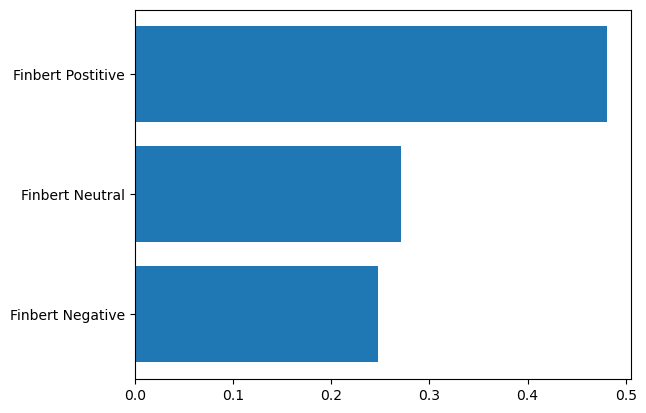

In [28]:
rforest = RandomForestRegressor(max_depth=2)
rfor=rforest.fit(X_train, y_train)
print(mean_squared_error(y_test, rforest.predict(X_test)))
snames, simportances = zip(*sorted(zip(feature_names, rforest.feature_importances_), 
                                   key=lambda pair: pair[1]))
plt.barh(snames, simportances)

Gradient Boosted R-Squared:  -0.2837333986389585
Random Forest R-Squared:  -0.14011380032954812
6.823773315432845


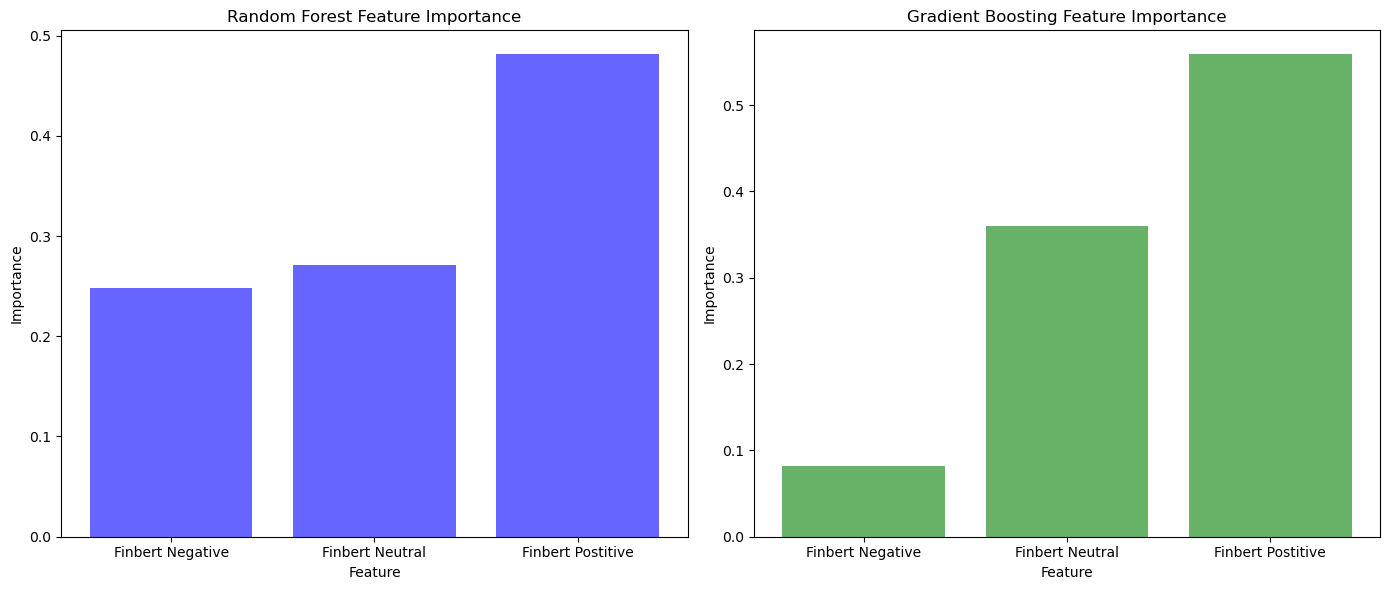

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=2, random_state=42)
gb_reg.fit(X_train, y_train)
score = gb_reg.score(X_test, y_test)
scorerf = rforest.score(X_test,y_test)
print('Gradient Boosted R-Squared: ',score)
print('Random Forest R-Squared: ',scorerf)
print(mean_squared_error(y_test, gb_reg.predict(X_test)))
# Get feature importances
rf_importance = rforest.feature_importances_
gb_importance = gb_reg.feature_importances_

# Plot the feature importances
feature_labels = X_train.columns.tolist()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(feature_labels, rf_importance, color='blue', alpha=0.6, label='Random Forest')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.subplot(1, 2, 2)
plt.bar(feature_labels, gb_importance, color='green', alpha=0.6, label='Gradient Boosting')
plt.title('Gradient Boosting Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.tight_layout()
plt.show()

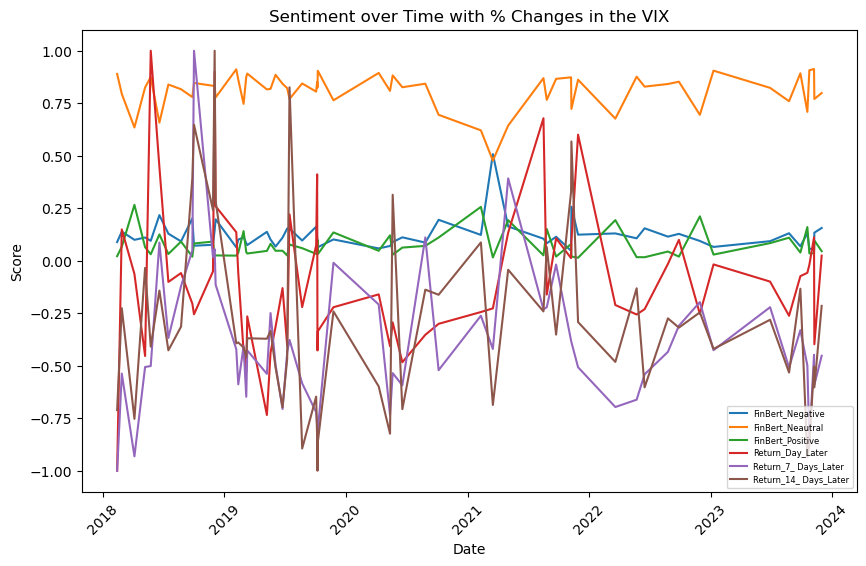

In [30]:
def min_max_scale(series, min_scale=-1, max_scale=1):
    min_val = series.min()
    max_val = series.max()
    scaled_series = min_scale + ((series - min_val) * (max_scale - min_scale)) / (max_val - min_val)
    return scaled_series
for column in ['Day_Avg_Return', '7_Day_Avg_Return', '14_Day_Avg_Return']:
    merged_sp[column] = min_max_scale(merged_sp[column], -1, 1)
for column in ['Day_Avg_Return', '7_Day_Avg_Return', '14_Day_Avg_Return']:
    merged_vix[column] = min_max_scale(merged_vix[column], -1, 1)
plt.figure(figsize=(10, 6))
#plt.plot(merged_vix['date'], merged_vix['Vader_Negative'], label='Vader_Negative')
#plt.plot(merged_vix['date'], merged_vix['Vader_Neutral'], label='Vader_Neautral')
#plt.plot(merged_vix['date'], merged_vix['Vader_Positive'], label='Vader_Positive')
plt.plot(merged_vix['date'], merged_vix['FinBert_Negative'], label='FinBert_Negative')
plt.plot(merged_vix['date'], merged_vix['FinBert_Neutral'], label='FinBert_Neautral')
plt.plot(merged_vix['date'], merged_vix['FinBert_Positive'], label='FinBert_Positive')

plt.plot(merged_vix['date'], merged_vix['Day_Avg_Return'], label='Return_Day_Later')
plt.plot(merged_vix['date'], merged_vix['7_Day_Avg_Return'], label='Return_7_ Days_Later')
plt.plot(merged_vix['date'], merged_vix['14_Day_Avg_Return'], label='Return_14_ Days_Later')

plt.title('Sentiment over Time with % Changes in the VIX')
plt.xlabel('Date')
plt.ylabel('Score')
legend = plt.legend(loc='lower right', fontsize = 6)
plt.xticks(rotation=45)
plt.show()

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train, y_train)
score = gb_reg.score(X_test, y_test)
print(score)

-1.7082400608931927


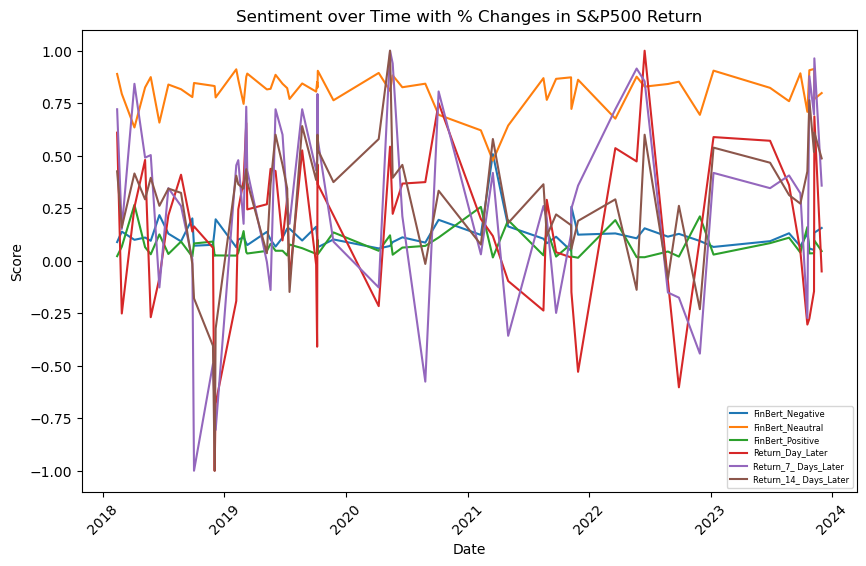

In [32]:
plt.figure(figsize=(10, 6))
#plt.plot(merged_vix['date'], merged_vix['Vader_Negative'], label='Vader_Negative')
#plt.plot(merged_vix['date'], merged_vix['Vader_Neutral'], label='Vader_Neautral')
#plt.plot(merged_vix['date'], merged_vix['Vader_Positive'], label='Vader_Positive')
plt.plot(merged_sp['date'], merged_sp['FinBert_Negative'], label='FinBert_Negative')
plt.plot(merged_sp['date'], merged_sp['FinBert_Neutral'], label='FinBert_Neautral')
plt.plot(merged_sp['date'], merged_sp['FinBert_Positive'], label='FinBert_Positive')

plt.plot(merged_sp['date'], merged_sp['Day_Avg_Return'], label='Return_Day_Later')
plt.plot(merged_sp['date'], merged_sp['7_Day_Avg_Return'], label='Return_7_ Days_Later')
plt.plot(merged_sp['date'], merged_sp['14_Day_Avg_Return'], label='Return_14_ Days_Later')

plt.title('Sentiment over Time with % Changes in S&P500 Return')
plt.xlabel('Date')
plt.ylabel('Score')
legend = plt.legend(loc='lower right', fontsize = 6)
plt.xticks(rotation=45)
plt.show()

In [33]:
# plt.figure(figsize=(10, 6))
# plt.plot(df['date'][:5], daily_sentiments_df['Negative'][:5], label='Vader_Negative')
# plt.plot(df['date'][:5], daily_sentiments_df['Neutral'][:5], label='Vader_Neutral')
# plt.plot(df['date'][:5], daily_sentiments_df['Positive'][:5], label='Vader_Positive')
# plt.plot(df['date'][:5], negative_scores, label='FinBert_Negative')
# plt.plot(df['date'][:5], neutral_scores, label='FinBert_Neutral')
# plt.plot(df['date'][:5], positive_scores, label='FinBert_Postive')
# plt.title('Daily Sentiment Index for Dates with COVID-related Words')
# plt.xlabel('Date')
# plt.ylabel('Sentiment Score')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()